In [15]:
# Import internal libraries
import json
from copy import deepcopy

# Import custom libraries
from helper import intersection, factors

# Import external libraries
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
# SET sweep data
setdata = pd.read_csv(f"../data/setsweep33.csv", delimiter="\t", names=["addr", "t", "vwl", "vbl", "pw"] + [f"gi[{i}]" for i in range(16)] + [f"gf[{i}]" for i in range(16)])
setdata = pd.concat([setdata[["addr","t","vwl","vbl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(16)])
setdata

,addr,t,vwl,vbl,pw,gi,gf
0,35887,1.685655e+09,0,0,1,8,8
1,6153,1.685655e+09,0,4,1,6,36
2,48880,1.685655e+09,0,8,1,10,43
3,9017,1.685655e+09,0,12,1,15,58
4,57814,1.685655e+09,0,16,1,7,49
...,...,...,...,...,...,...,...
257820,60529,1.685767e+09,34,12,2,19,43
257821,36999,1.685767e+09,34,16,2,9,50
257822,37637,1.685767e+09,34,20,2,8,57
257823,15529,1.685767e+09,34,24,2,10,59


In [17]:
# RESET sweep data
resetdata = pd.read_csv(f"../data/resetsweep33.csv", delimiter="\t", names=["addr", "t", "vwl", "vsl", "pw"] + [f"gi[{i}]" for i in range(16)] + [f"gf[{i}]" for i in range(16)])
resetdata = pd.concat([resetdata[["addr","t","vwl","vsl","pw",f"gi[{i}]",f"gf[{i}]"]].rename(columns={f"gi[{i}]" : "gi", f"gf[{i}]" : "gf"}) for i in range(16)])
resetdata

,addr,t,vwl,vsl,pw,gi,gf
0,11143,1.685598e+09,0,0,1,50,49
1,29218,1.685598e+09,0,4,1,46,46
2,62070,1.685598e+09,0,8,1,37,41
3,47766,1.685598e+09,0,12,1,3,6
4,13916,1.685598e+09,0,16,1,10,11
...,...,...,...,...,...,...,...
263629,40100,1.685664e+09,226,8,16,47,47
263630,9371,1.685664e+09,226,12,16,38,25
263631,8726,1.685664e+09,226,16,16,62,62
263632,30210,1.685664e+09,226,20,16,64,64


In [18]:
# Load configuration template
config_tmpl = json.load(open("../settings/form.json"))
config_tmpl["level_settings"][1].update({"wl_dac_set_lvl_start": 0, "wl_dac_set_lvl_stop": 1, "wl_dac_set_lvl_step": 1})

tailstart, avgopt, tailstop = 19 25 27


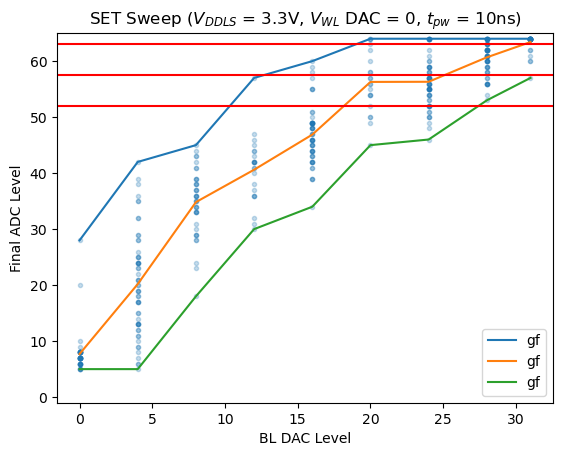

tailstart, avgopt, tailstop = 4 11 17


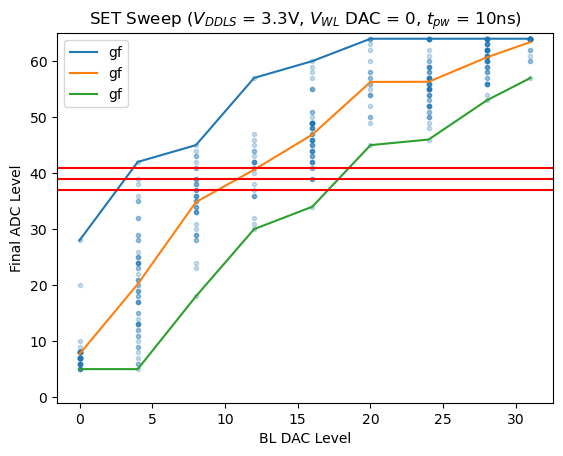

tailstart, avgopt, tailstop = 12 19 27


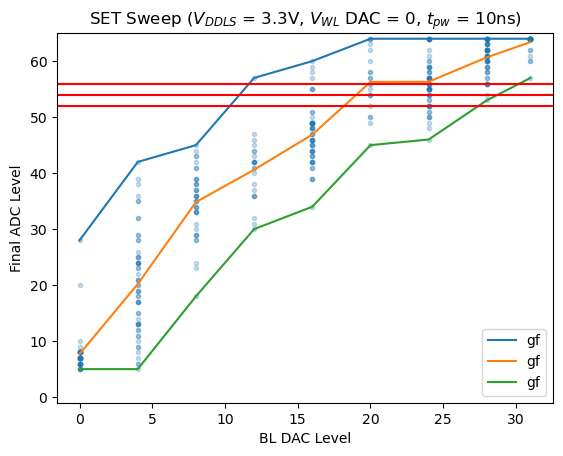

tailstart, avgopt, tailstop = 19 30 0


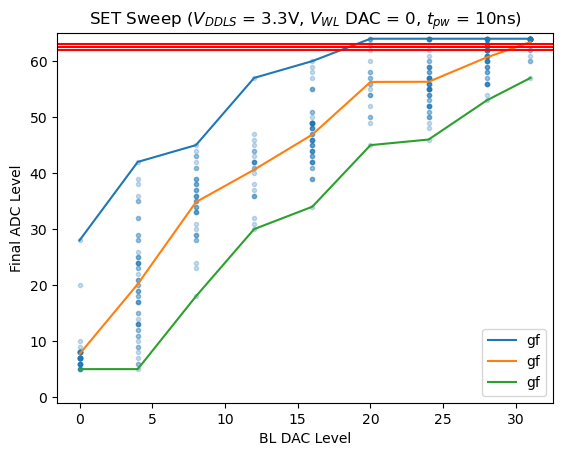

In [19]:
# FIRST-ORDER OPTIMIZATION
# Iterate over number of bits per cell
for bpc in range(1, 3):
  bpc_config = json.load(open(f"../settings/{bpc}bpc.json"))
  for i, level_settings in enumerate(bpc_config["level_settings"]):
    # Get levels
    write_between = level_settings["adc_lower_write_ref_lvl"], level_settings["adc_upper_write_ref_lvl"]
    read_lvl = level_settings["adc_upper_read_ref_lvl"]

    # Generate SET experiment configs
    configs = []
    if i != 0: # No SET optimization needed for lowest/highest level
      # Get data
      d = setdata[(setdata["gi"].isin(range(5,9))) & (setdata["pw"] == 1) & (setdata["vwl"] == 0)][["vbl","gf"]]
      
      # Get tail-start, avg-opt, tail-stop
      tailstart = int(np.round(intersection(np.array([0,31]),np.array([write_between[1], write_between[1]]), d.groupby('vbl').max().reset_index()['vbl'], d.groupby('vbl').max().reset_index()['gf'])[0][0]))
      avgopt = int(np.round(intersection(np.array([0,31]),np.array([(write_between[1] + write_between[0])/2, (write_between[1] + write_between[0])/2]), d.groupby('vbl').mean().reset_index()['vbl'], d.groupby('vbl').mean().reset_index()['gf'])[0][0]))
      try:
        tailstop = int(np.round(intersection(np.array([0,31]),np.array([write_between[0], write_between[0]]), d.groupby('vbl').min().reset_index()['vbl'], d.groupby('vbl').min().reset_index()['gf'])[0][0]))
      except IndexError:
        tailstop = 0
      print("tailstart, avgopt, tailstop =", tailstart, avgopt, tailstop)

      # Plot sweep
      pw = 1
      plt.scatter(d['vbl'], d['gf'], marker='.', alpha=0.25)
      d.groupby('vbl').max().plot(ax=plt.gca(), label="Max")
      d.groupby('vbl').mean().plot(ax=plt.gca(), label="Mean")
      d.groupby('vbl').min().plot(ax=plt.gca(), label="Min")
      plt.axhline(write_between[0], color='r')
      plt.axhline((write_between[1] + write_between[0])/2, color='r')
      plt.axhline(write_between[1], color='r')
      plt.title(f"SET Sweep ($V_{{DDLS}}$ = 3.3V, $V_{{WL}}$ DAC = 0, $t_{{pw}}$ = {pw*10}ns)", y=1)
      plt.xlabel("BL DAC Level")
      plt.ylabel("Final ADC Level")
      plt.ylim(-1, 65)
      plt.legend()
      plt.show()

      # Generate configurations
      stop = 31
      j = 0 # experiment number
      for pw in range(1, 3):
        for start in range(tailstart, avgopt + 1):
          for step in factors(stop - start):
            # Copy config template from form.json
            config = deepcopy(config_tmpl)

            # Update level settings
            config["level_settings"][1].update({"pw_set_start": pw, "pw_set_stop": pw + 1, "bl_dac_set_lvl_start": start, "bl_dac_set_lvl_stop": stop, "bl_dac_set_lvl_step": step, "adc_upper_read_ref_lvl": read_lvl, "adc_lower_write_ref_lvl": write_between[0], "adc_upper_write_ref_lvl": write_between[1]})

            # Write out experiments as configs
            with open(f"configs/config_{bpc}bpc_lvl{i}_{str(j).zfill(4)}.json", 'w') as outf:
              json.dump(config, outf, indent=1)

            # Increment j
            j += 1
